In [1]:
import pymatgen as mg
import pymatgen.analysis.diffraction as anadi
import pymatgen.analysis.diffraction.xrd as xrd
import numpy as np
import os
import re
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [2]:
patt_xrd = xrd.XRDCalculator('CuKa')

In [3]:
train_path='/Users/junjiehu/Desktop/202210test/train/'

test_path='/Users/junjiehu/Desktop/202210test/test/'

In [4]:
global sample_num, rmat_num, series_num
sample_num=1 #output of G
rmat_num=28 

In [5]:
def get_energy(folder):
    energy_string=os.popen('grep TOTEN '+folder+'/OUTCAR | tail -1').read().split(' ')[-2]
    energy=round(np.float64(float(energy_string)),5)
    return energy

def linear_transform(energy):
    global extend_num, move_num
    energy_transform=(energy-move_num)*extend_num
    return energy_transform

def inverse_transform(energy_transform):
    global extend_num, move_num
    energy=energy_transform/extend_num+move_num
    return energy

def get_energy_per_atom(energy):
    energy_per_atom=energy/atoms_num
    return energy_per_atom

In [6]:
global extend_num, move_num

In [7]:
extend_num=1000

In [8]:
move_num=get_energy(train_path+'00000/')
print(move_num)

-122.69044


In [9]:
def tomgStructure(folder):
    POSfile = folder+'/CONTCAR'      
    R_mgS = mg.core.Structure.from_file(POSfile)
    return R_mgS

###
##input_data_to_model
###
def get_xrdmat3(mgStructure):
    global rmat_num
    xrd_data4 = patt_xrd.get_pattern(mgStructure)
    xrd_data4.y= xrd_data4.y-base_pxrd.y
    i_column = rmat_num
    xxx = []
    yyy = []
    mat4 = []
    xrd_i = len(xrd_data4)
    for i in range(xrd_i):
        if abs(xrd_data4.y[i]) > 0.00001:
            xxx.append(xrd_data4.x[i])
            yyy.append(xrd_data4.y[i])
    mat4.append(np.asarray(xxx))
    mat4.append(np.asarray(yyy))
    mat4 = np.asarray(mat4)
    
    xrd_x=[]
    xrd_y=[]
    xrd_mat4=[]
    xrow=len(mat4[0])
    
    if xrow < i_column:
        for i in mat4[0]:
            xrd_x.append(i)
        for j in mat4[1]:
            xrd_y.append(j)
        for i in range(0,i_column-xrow):
            xrd_x.append(0)
            xrd_y.append(0)
        xrd_x=np.asarray(xrd_x)
        xrd_y=np.asarray(xrd_y)
    if xrow > i_column:
        xrd_x=mat4[0][:i_column]
        xrd_y=mat4[1][:i_column]
    if xrow == i_column:
        xrd_x= mat4[0]
        xrd_y= mat4[1]
        
    
    xrd_x=np.sin(np.dot(1/180*np.pi,xrd_x))
    xrd_y=np.dot(100,xrd_y)
    xrd_mat4.append(xrd_x)
    xrd_mat4.append(xrd_y)
    xrd_mat4=np.array(xrd_mat4)
    return xrd_mat4
###
##input_data_as_knowlegde
###
'''
def get_Gibbs(folder):
    energy_string=os.popen('grep TOTEN '+folder+'/OUTCAR | tail -1').read().split(' ')[-2]
    Gibbs=np.float64(float(energy_string))
    Gibbs=round(Gibbs,6)
    return Gibbs
'''
##
###
def get_atoms_num(folder2):
    xxx=tomgStructure(folder2)
    anum=len(xxx.sites)
    return anum


###
##input_data_for_G
###
def GANs_Gmat(Random_Structure):
    global rmat_num
    RS_xrdmat = get_xrdmat3(Random_Structure)
    multimat3_RS =  np.zeros((rmat_num,rmat_num),dtype='float32')
    multimat3_RS = np.asarray((np.dot(RS_xrdmat.T, RS_xrdmat)))
    return multimat3_RS

In [10]:
base_pxrd_s=mg.core.Structure.from_file(train_path+'00000/CONTCAR')
base_pxrd=patt_xrd.get_pattern(base_pxrd_s)

In [11]:
def model_input_svm(floder):
    #input
    model_input=[]
    model_input_mgs=tomgStructure(floder)
    model_input_mgs=GANs_Gmat(model_input_mgs)
    model_input.append(model_input_mgs)
    model_input=np.asarray(model_input)
    model_input=model_input.reshape(model_input.size)
    return model_input

In [12]:
flag_set=[]
file_path_set=[]
work_path=train_path
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set.append(ieach)
        ieach=work_path+ieach
        file_path_set.append(ieach)

In [15]:
energy_label=[]
Y_train=[]
for pnum in range(len(file_path_set)):
    try:
        eee = get_energy(file_path_set[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y_train.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set[pnum])

In [16]:
X_train=[]
for pnum in range(len(file_path_set)):
    try:
        X_train.append(model_input_svm(file_path_set[pnum]))
    except:
        print('inputX error:', file_path_set[pnum])

In [18]:
flag_set_test=[]
file_path_set_test=[]
work_path=test_path
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set_test.append(ieach)
        ieach=work_path+ieach
        file_path_set_test.append(ieach)

In [19]:
energy_label_test=[]
Y_test=[]
for pnum in range(len(file_path_set_test)):
    try:
        eee = get_energy(file_path_set_test[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y_test.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set_test[pnum] )

In [20]:
X_test=[]
for pnum in range(len(file_path_set_test)):
    try:
        X_test.append(model_input_svm(file_path_set_test[pnum]))
    except:
        print('inputX error:', file_path_set_test[pnum])

In [21]:
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

In [28]:
def cal_MAE(predict, label):
    MAEerr=[]
    for i in range(len(label)):
        err = inverse_transform(predict[i]) - inverse_transform(label[i])
        MAEerr.append(err)
    out = np.mean(np.abs(np.asarray(MAEerr)))
    return out

In [33]:
svr_lin.fit(np.asarray(X_train), np.asarray(Y_train))

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma='auto', kernel='linear')

In [34]:
y_predict_lin_train = svr_lin.predict(X_train)

In [35]:
cal_MAE(y_predict_lin_train, Y_train)

3.743383077789738

In [36]:
y_predict_lin_test = svr_lin.predict(X_test)

In [37]:
cal_MAE(y_predict_lin_test,Y_test)

28.026347338634597

In [38]:
svr_lin.get_params()
        

{'C': 100,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
dir_file = '/Users/junjiehu/Mlearning/MaterialsML/DFT-bluk-cpx222/'

In [40]:
flag_set=[]
file_path_set=[]
work_path=dir_file
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set.append(ieach)
        ieach=work_path+ieach
        file_path_set.append(ieach)

In [41]:
energy_label=[]
Y=[]
for pnum in range(len(file_path_set)):
    try:
        eee = get_energy(file_path_set[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set[pnum] )

In [42]:
X=[]
for pnum in range(len(file_path_set)):
    try:
        X.append(model_input_svm(file_path_set[pnum]))
    except:
        print('inputX error:', file_path_set[pnum])

In [49]:
XXX1=np.asarray(X_test)[:500]

In [50]:
XXX1.shape

(500, 784)

In [47]:
XXX = np.asarray(X_test)[500:]

In [48]:
XXX.shape

(1000, 784)

In [51]:
y_predict = svr_lin.predict(XXX)

In [52]:
cal_MAE(y_predict,Y)

15.884865208212169

In [53]:
import numpy as np
import os
from sklearn.manifold import TSNE

In [54]:
def extract(flodername):    
    with open(flodername+'/'+'CONTCAR') as f:
        lol=[line.strip().split('\n') for line in f]#逐行读取，并存储为数组结构
    matr_s_o=[]#存放晶格常数的3*3数组    
    matr_o=[]
    
    formula_element=''#存放原子类型
    amount_element=''#存放晶胞中原子个数
    
    matr_data_o=[]
    matr_data_0=[]
    matr_data=[]
    for i in lol[2:5]:

        jjj=[]

        for j in i[0].split(' '):
            if j !='':
                jjj.append(j)

        matr_s_o.append(jjj)
   
    for k in matr_s_o:
        matr_o.append([float(l) for l in k])
    
    amount_element=lol[5]
    
    for n in lol[9:49]:#文件第10行开始读数据

        n[0]=n[0][:-10]
        mmm=[]
        for m in n[0].split(' '):
        #        print(m)
            if m !='':
                mmm.append(m)
           # print(mmm)
        matr_data_o.append(mmm)
        
    for p in matr_data_o:
        matr_data_0.append([float(q) for q in p]) 
    
    matr_out=matr_o
    amount_element_out=amount_element[0]
    matr_data_0=matr_data_0
    
    return matr_out, amount_element_out, matr_data_0

In [58]:
DFT_label=inverse_transform(np.asarray(Y))

In [59]:
svr_predict=inverse_transform(np.asarray(y_predict))

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

In [62]:
def get_tSNE_input(path_):
    input_vector_poscar=[]
    a,b,c=extract(path_)
    #energy=get_energy(path_)
    siteZero=np.asarray([0.5,0.5,0.5])
    Br_I_atoms=c[16:]
    coordinate=np.dot(np.asarray(Br_I_atoms),np.asarray(a))
    #print(len(coordinate))
    for i in range(len(coordinate)):
        input_vector=[]
        if i <=18:
            #print(coordinate[i])
            input_vector.append(2.8)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
        else:
            input_vector.append(2.5)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
    input_vector_poscar=np.asarray(input_vector_poscar)
    input_vector_poscar=input_vector_poscar.reshape((24*4),order="C")
    return input_vector_poscar

In [63]:
tSNE_input=[]
for pnum in range(len(file_path_set)):
    try:
        path_=file_path_set[pnum]
        tSNE_input.append(get_tSNE_input(path_))
    except:
        print('error:',file_path_set[pnum])

In [65]:
tsne = TSNE(min_grad_norm=1e-3,init='pca',method='exact',angle=1,early_exaggeration=5,n_iter=1000)

In [66]:
tSNE_input = np.asarray(tSNE_input)

In [67]:
tsne_output = tsne.fit_transform(tSNE_input)

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [68]:
lx = tsne_output.T[0]
ly = tsne_output.T[1]

In [69]:
minz = np.min(svr_predict)
maxz = np.max(svr_predict)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -212.52725342396917
maximum: 240.35241228934112
scale: 452.87966571331026
-212.52725342396917 -121.95132028130712 -31.375387138645067 59.200546004016985 149.77647914667904 240.35241228934112


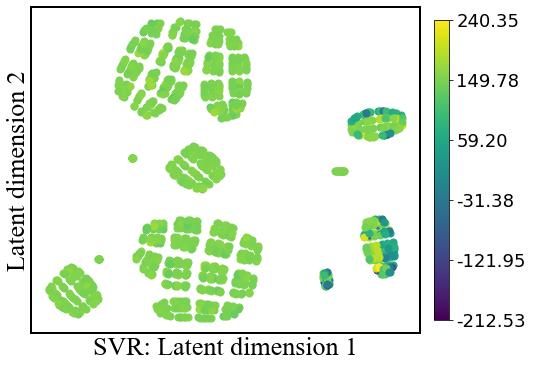

In [72]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(lx)):
    color1=cm.viridis_r(int(256*(svr_predict[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(lx[i],ly[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-212.53', '-121.95', '-31.38', '59.20', '149.78', '240.35'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('SVR: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('SVRmodel-3.jpg')

In [ ]:
svr_poly.fit(np.asarray(X_train), np.asarray(Y_train))

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
 .